In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import shap
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn
import sklearn
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Read Files

In [2]:
csv_folder = 'C:/Users/Neil/OneDrive/Documents/Capstone Files/' ### make sure na lahat ng csv ay nasa isang folder tapos dapat yung features lang yung nandun
csv_files = sorted(glob.glob(os.path.join(csv_folder, "*.csv")))  # Get all CSV files

In [3]:
csv_files

['C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M1-24.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M13-36.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M25-48.csv',
 'C:/Users/Neil/OneDrive/Documents/Capstone Files\\Car Features M37-60.csv']

## Splitting

In [4]:
selected_features = [
    'EverAtLeast1DPD_3mos', 
    'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 
    'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 
    'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 
    'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 
    'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 
    'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 
    'WorstDel_9mos', 'WorstDel_12mos', 
    'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 
    'Partial_past3mos', 
    'Full_past3mos', 'Missed_past6mos', 
    'Partial_past6mos', 
    'Full_past6mos', 
    'Missed_past9mos', 
    'Partial_past9mos', 
    'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 
    'Full_past12mos'
]


# Lists to store all training and testing data
X_train_list, X_test_list, y_train_list, y_test_list = [], [], [], []

# Process each CSV file
for file in csv_files:
    print(f"\nProcessing file: {file}")
    
    # Read the CSV file
    data = pd.read_csv(file)

    X = data[selected_features]
    y = data['DEFAULT_TAGGING']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    # Append to lists
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

    # Print class balance
    print("Train class balance:\n", y_train.value_counts(normalize=True))
    print("Test class balance:\n", y_test.value_counts(normalize=True))

# Merge all train and test data
X_train_all = pd.concat(X_train_list, axis=0)
X_test_all = pd.concat(X_test_list, axis=0)
y_train_all = pd.concat(y_train_list, axis=0)
y_test_all = pd.concat(y_test_list, axis=0)

print("\nFinal Merged Data Shapes:")
print("X_train_all:", X_train_all.shape)
print("X_test_all:", X_test_all.shape)
print("y_train_all:", y_train_all.shape)
print("y_test_all:", y_test_all.shape)


Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M1-24.csv
Train class balance:
 DEFAULT_TAGGING
0    0.998525
1    0.001475
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.998513
1    0.001487
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M13-36.csv
Train class balance:
 DEFAULT_TAGGING
0    0.994214
1    0.005786
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.994182
1    0.005818
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M25-48.csv
Train class balance:
 DEFAULT_TAGGING
0    0.986499
1    0.013501
Name: proportion, dtype: float64
Test class balance:
 DEFAULT_TAGGING
0    0.98652
1    0.01348
Name: proportion, dtype: float64

Processing file: C:/Users/Neil/OneDrive/Documents/Capstone Files\Car Features M37-60.csv
Train class balance:
 DEFAULT_TAGGING
0    0.974224


In [5]:
X_train_split_0, X_val, y_train_split_0, y_val = train_test_split(
    X_train_all, y_train_all, test_size=0.3, random_state=42, stratify=y_train_all
)

print("\nFinal Split Data Shapes:")
print("X_train_split_0:", X_train_split_0.shape)
print("X_val:", X_val.shape)
print("y_train_split_0:", y_train_split_0.shape)
print("y_val:", y_val.shape)


Final Split Data Shapes:
X_train_split_0: (78197, 33)
X_val: (33514, 33)
y_train_split_0: (78197,)
y_val: (33514,)


In [6]:
Y1= pd.concat([X_train_split_0, y_train_split_0], axis=1)

In [7]:
Y1

,EverAtLeast1DPD_3mos,EverAtLeast15DPD_3mos,EverAtLeast31DPD_3mos,EverAtLeast61DPD_3mos,EverAtLeast1DPD_6mos,EverAtLeast15DPD_6mos,EverAtLeast31DPD_6mos,EverAtLeast61DPD_6mos,EverAtLeast1DPD_9mos,EverAtLeast15DPD_9mos,...,Missed_past6mos,Partial_past6mos,Full_past6mos,Missed_past9mos,Partial_past9mos,Full_past9mos,Missed_past12mos,Partial_past12mos,Full_past12mos,DEFAULT_TAGGING
11757,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
39534,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
9963,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
72838,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,1,0,11,0
40217,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
972,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,2,0,10,0
24028,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,0,0,12,0
36067,0,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,9,2,0,10,0
24985,0,0,0,0,0,0,0,0,1,0,...,1,0,5,2,0,7,3,0,9,0


In [8]:
# Define X1 (features) and y1 (target)
X_1 = Y1.drop(columns=["DEFAULT_TAGGING"])  
Y_1 = Y1["DEFAULT_TAGGING"].astype(int)  # Convert target to integer Series

In [9]:
from imblearn.over_sampling import SMOTENC
# import numpy as np
# import pandas as pd
from collections import Counter

# Define feature groups
binary_features = ['EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos',
                   'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos',
                   'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos',
                   'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos']

ordinal_features = ['WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos']

continuous_features = ['RemainingLoanRatio_12mos']

count_features = ['Missed_past3mos', 'Partial_past3mos', 'Full_past3mos',
                  'Missed_past6mos', 'Partial_past6mos', 'Full_past6mos',
                  'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos',
                  'Missed_past12mos', 'Partial_past12mos', 'Full_past12mos']

# Get categorical feature indices for SMOTE-NC  
categorical_feature_indices = [X_1.columns.get_loc(col) for col in binary_features + ordinal_features]

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy=0.50)
X1_resampled, Y1_resampled = smote_nc.fit_resample(X_1, Y_1)

# Convert back to DataFrame
x1_resampled = pd.DataFrame(X1_resampled, columns=X_1.columns)
y1_resampled = pd.Series(Y1_resampled, name="DEFAULT_TAGGING")

# Post-processing: Round categorical & count features
x1_resampled[binary_features] = x1_resampled[binary_features].round().astype(int)
x1_resampled[ordinal_features] = x1_resampled[ordinal_features].round().astype(int)
x1_resampled[count_features] = x1_resampled[count_features].round().astype(int)

# Print class distribution
print("Before SMOTE:", Counter(Y_1))
print("After SMOTE:", Counter(y1_resampled))

Before SMOTE: Counter({0: 77699, 1: 498})
After SMOTE: Counter({0: 77699, 1: 38849})


In [10]:
Y1_resampled = pd.concat([x1_resampled, y1_resampled], axis=1)

# Check if rows are still aligned properly
print(Y1_resampled.tail())  # Preview first few rows

        EverAtLeast1DPD_3mos  EverAtLeast15DPD_3mos  EverAtLeast31DPD_3mos  \
116543                     1                      1                      1   
116544                     1                      1                      1   
116545                     1                      1                      1   
116546                     0                      0                      0   
116547                     1                      1                      1   

        EverAtLeast61DPD_3mos  EverAtLeast1DPD_6mos  EverAtLeast15DPD_6mos  \
116543                      1                     1                      1   
116544                      1                     1                      1   
116545                      1                     1                      1   
116546                      0                     0                      0   
116547                      0                     1                      1   

        EverAtLeast31DPD_6mos  EverAtLeast61DPD_6mos  EverAtLe

In [12]:
xvars = [
    'EverAtLeast1DPD_3mos', 'EverAtLeast15DPD_3mos', 'EverAtLeast31DPD_3mos', 'EverAtLeast61DPD_3mos', 
    'EverAtLeast1DPD_6mos', 'EverAtLeast15DPD_6mos', 'EverAtLeast31DPD_6mos', 'EverAtLeast61DPD_6mos', 
    'EverAtLeast1DPD_9mos', 'EverAtLeast15DPD_9mos', 'EverAtLeast31DPD_9mos', 'EverAtLeast61DPD_9mos', 
    'EverAtLeast1DPD_12mos', 'EverAtLeast15DPD_12mos', 'EverAtLeast31DPD_12mos', 'EverAtLeast61DPD_12mos', 
    'WorstDel_3mos', 'WorstDel_6mos', 'WorstDel_9mos', 'WorstDel_12mos', 'RemainingLoanRatio_12mos', 
    'Missed_past3mos', 'Partial_past3mos', 'Full_past3mos', 'Missed_past6mos', 'Partial_past6mos', 
    'Full_past6mos', 'Missed_past9mos', 'Partial_past9mos', 'Full_past9mos', 'Missed_past12mos', 
    'Partial_past12mos', 'Full_past12mos'
]

yvar = 'DEFAULT_TAGGING'  # Target variable for y1

# Prepare training data (y1)
X_train_split = Y1_resampled[xvars]
y_train_split = Y1_resampled[yvar]

#### Option 1 Grid Search 

In [13]:
from sklearn.metrics import recall_score, confusion_matrix, precision_recall_curve
import lightgbm as lgb
import numpy as np
from itertools import product

def calculate_specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

#change param_grid based on your chosen range of values
def grid_search_lgbm(X_train_split, y_train_split, X_val, y_val):
    param_grid = {
        'num_leaves': np.linspace(20, 100, 5, dtype=int),
        'learning_rate': np.linspace(0.03, 0.15, 5),
        'num_iterations': np.linspace(50, 200, 4, dtype=int)
    }

    best_results = {
        'recall': {'score': -np.inf, 'params': None},
        'specificity': {'score': -np.inf, 'params': None}
    }

    print("Starting Grid Search for num_leaves, learning_rate, and num_iterations...\n")

    for num_leaves, learning_rate, num_iterations in product(
        param_grid['num_leaves'], param_grid['learning_rate'], param_grid['num_iterations']
    ):
        model = lgb.LGBMClassifier(
            boosting_type='gbdt',
            objective='binary',
            metric='binary_logloss',
            learning_rate=learning_rate,
            num_iterations=num_iterations,
            num_leaves=num_leaves,
            is_unbalanced=True,
            random_state=42,
            bagging_seed=42,
            feature_fraction_seed=42,
            drop_seed=42,
            data_random_seed=42,
            deterministic=True,
            n_jobs=1
        )

        model.fit(X_train_split, y_train_split)
        y_proba = model.predict_proba(X_val)

        # Threshold tuning based on maximum F1 score
        precision, recall_arr, thresholds = precision_recall_curve(y_val, y_proba[:, 1])
        f1_scores = 2 * (precision * recall_arr) / (precision + recall_arr)  # Avoid divide-by-zero
        optimal_threshold = thresholds[np.argmax(f1_scores)]

        # Apply optimal threshold
        y_pred = (y_proba[:, 1] >= optimal_threshold).astype(int)

        recall = recall_score(y_val, y_pred)
        specificity = calculate_specificity(y_val, y_pred)

        print(f"Params: num_leaves={num_leaves}, learning_rate={learning_rate:.3f}, num_iterations={num_iterations}")
        print(f" → Optimal Threshold: {optimal_threshold:.4f}")
        print(f" → Recall: {recall:.4f}, Specificity: {specificity:.4f}\n")

        if recall > best_results['recall']['score']:
            best_results['recall'] = {
                'score': recall,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

        if specificity > best_results['specificity']['score']:
            best_results['specificity'] = {
                'score': specificity,
                'params': {
                    'num_leaves': num_leaves,
                    'learning_rate': learning_rate,
                    'num_iterations': num_iterations,
                    'threshold': optimal_threshold
                }
            }

    # Print final best results
    print("Grid Search Complete!\n")
    print("Best Recall Score:")
    print(f" → Score: {best_results['recall']['score']:.4f}")
    print(f" → Params: {best_results['recall']['params']}\n")

    print("Best Specificity Score:")
    print(f" → Score: {best_results['specificity']['score']:.4f}")
    print(f" → Params: {best_results['specificity']['params']}\n")

    return best_results

In [14]:
results = grid_search_lgbm(X_train_split, y_train_split, X_val, y_val)
print(results)

Starting Grid Search for num_leaves, learning_rate, and num_iterations...

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 73
True Positives (TP): 140
Params: num_leaves=20, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.8366
 → Recall: 0.6573, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=20, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9201
 → Recall: 0.7465, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9281
 → Recall: 0.7512, Specificity: 0.9996



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9384
 → Recall: 0.7512, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unb

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=20, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9164
 → Recall: 0.7559, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=20, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9405
 → Recall: 0.7465, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9296
 → Recall: 0.7512, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9142
 → Recall: 0.7512, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9298
 → Recall: 0.7512, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=20, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9590
 → Recall: 0.7371, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 55
True Positives (TP): 158
Params: num_leaves=20, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9531
 → Recall: 0.7418, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=20, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9219
 → Recall: 0.7371, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33288
False Positives (FP): 13
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=20, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9446
 → Recall: 0.7512, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 54
True Positives (TP): 159
Params: num_leaves=20, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9229
 → Recall: 0.7465, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=20, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9443
 → Recall: 0.7183, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=20, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9441
 → Recall: 0.6761, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=20, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9562
 → Recall: 0.7183, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=20, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9423
 → Recall: 0.7089, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=20, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9602
 → Recall: 0.6808, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=20, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9502
 → Recall: 0.6761, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025821 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33281
False Positives (FP): 20
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=40, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.8360
 → Recall: 0.7089, Specificity: 0.9994

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=40, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9410
 → Recall: 0.7277, Specificity: 0.9997



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 56
True Positives (TP): 157
Params: num_leaves=40, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9505
 → Recall: 0.7371, Specificity: 0.9997



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=40, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9708
 → Recall: 0.7277, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=40, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9410
 → Recall: 0.7277, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=40, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9664
 → Recall: 0.7277, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=40, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9390
 → Recall: 0.7183, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=40, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9684
 → Recall: 0.6854, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=40, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9490
 → Recall: 0.7324, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=40, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9367
 → Recall: 0.7230, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=40, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9575
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=40, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9668
 → Recall: 0.6854, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 59
True Positives (TP): 154
Params: num_leaves=40, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9737
 → Recall: 0.7230, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=40, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9549
 → Recall: 0.7136, Specificity: 0.9998



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=40, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9706
 → Recall: 0.6808, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=40, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9560
 → Recall: 0.6901, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=40, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9612
 → Recall: 0.7183, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=40, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9687
 → Recall: 0.7089, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021576 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=40, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9796
 → Recall: 0.6948, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017640 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33291
False Positives (FP): 10
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=40, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9786
 → Recall: 0.6948, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33265
False Positives (FP): 36
False Negatives (FN): 50
True Positives (TP): 163
Params: num_leaves=60, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.8162
 → Recall: 0.7653, Specificity: 0.9989

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022940 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=60, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9490
 → Recall: 0.7183, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=60, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9672
 → Recall: 0.7136, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 60
True Positives (TP): 153
Params: num_leaves=60, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9562
 → Recall: 0.7183, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=60, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9539
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=60, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9732
 → Recall: 0.7089, Specificity: 0.9999



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=60, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9586
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=60, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9627
 → Recall: 0.6948, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=60, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9766
 → Recall: 0.7089, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=60, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9375
 → Recall: 0.7277, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=60, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9557
 → Recall: 0.6948, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=60, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9613
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024553 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=60, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9707
 → Recall: 0.7089, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=60, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9691
 → Recall: 0.6808, Specificity: 0.9998



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 70
True Positives (TP): 143
Params: num_leaves=60, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9818
 → Recall: 0.6714, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=60, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9756
 → Recall: 0.6854, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=60, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9709
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=60, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9631
 → Recall: 0.6995, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=60, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9683
 → Recall: 0.6948, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 71
True Positives (TP): 142
Params: num_leaves=60, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9922
 → Recall: 0.6667, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020962 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33266
False Positives (FP): 35
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=80, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.8177
 → Recall: 0.7559, Specificity: 0.9989

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33281
False Positives (FP): 20
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=80, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9153
 → Recall: 0.7324, Specificity: 0.9994



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=80, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9687
 → Recall: 0.7136, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=80, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9823
 → Recall: 0.6854, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020241 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33285
False Positives (FP): 16
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=80, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9261
 → Recall: 0.7277, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019523 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 65
True Positives (TP): 148
Params: num_leaves=80, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9814
 → Recall: 0.6948, Specificity: 0.9999



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=80, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9742
 → Recall: 0.6995, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=80, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9681
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=80, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9776
 → Recall: 0.7089, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 63
True Positives (TP): 150
Params: num_leaves=80, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9649
 → Recall: 0.7042, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=80, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9782
 → Recall: 0.6808, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=80, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9880
 → Recall: 0.6808, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 57
True Positives (TP): 156
Params: num_leaves=80, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9516
 → Recall: 0.7324, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 67
True Positives (TP): 146
Params: num_leaves=80, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9823
 → Recall: 0.6854, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=80, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9891
 → Recall: 0.6808, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unba

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 70
True Positives (TP): 143
Params: num_leaves=80, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9955
 → Recall: 0.6714, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33273
False Positives (FP): 28
False Negatives (FN): 52
True Positives (TP): 161
Params: num_leaves=80, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9064
 → Recall: 0.7559, Specificity: 0.9992

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 71
True Positives (TP): 142
Params: num_leaves=80, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9874
 → Recall: 0.6667, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33300
False Positives (FP): 1
False Negatives (FN): 74
True Positives (TP): 139
Params: num_leaves=80, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9963
 → Recall: 0.6526, Specificity: 1.0000

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 72
True Positives (TP): 141
Params: num_leaves=80, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 0.9964
 → Recall: 0.6620, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33266
False Positives (FP): 35
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=100, learning_rate=0.030, num_iterations=50
 → Optimal Threshold: 0.8349
 → Recall: 0.7512, Specificity: 0.9989

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.030, num_iterations=100
 → Optimal Threshold: 0.9564
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016918 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33289
False Positives (FP): 12
False Negatives (FN): 62
True Positives (TP): 151
Params: num_leaves=100, learning_rate=0.030, num_iterations=150
 → Optimal Threshold: 0.9700
 → Recall: 0.7089, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33296
False Positives (FP): 5
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=100, learning_rate=0.030, num_iterations=200
 → Optimal Threshold: 0.9741
 → Recall: 0.6808, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.060, num_iterations=50
 → Optimal Threshold: 0.9583
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33290
False Positives (FP): 11
False Negatives (FN): 64
True Positives (TP): 149
Params: num_leaves=100, learning_rate=0.060, num_iterations=100
 → Optimal Threshold: 0.9566
 → Recall: 0.6995, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33297
False Positives (FP): 4
False Negatives (FN): 70
True Positives (TP): 143
Params: num_leaves=100, learning_rate=0.060, num_iterations=150
 → Optimal Threshold: 0.9825
 → Recall: 0.6714, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=100, learning_rate=0.060, num_iterations=200
 → Optimal Threshold: 0.9736
 → Recall: 0.6761, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unb

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33286
False Positives (FP): 15
False Negatives (FN): 58
True Positives (TP): 155
Params: num_leaves=100, learning_rate=0.090, num_iterations=50
 → Optimal Threshold: 0.9389
 → Recall: 0.7277, Specificity: 0.9995

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 71
True Positives (TP): 142
Params: num_leaves=100, learning_rate=0.090, num_iterations=100
 → Optimal Threshold: 0.9735
 → Recall: 0.6667, Specificity: 0.9998



C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33295
False Positives (FP): 6
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=100, learning_rate=0.090, num_iterations=150
 → Optimal Threshold: 0.9815
 → Recall: 0.6761, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unb

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 69
True Positives (TP): 144
Params: num_leaves=100, learning_rate=0.090, num_iterations=200
 → Optimal Threshold: 0.9937
 → Recall: 0.6761, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 61
True Positives (TP): 152
Params: num_leaves=100, learning_rate=0.120, num_iterations=50
 → Optimal Threshold: 0.9444
 → Recall: 0.7136, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33299
False Positives (FP): 2
False Negatives (FN): 70
True Positives (TP): 143
Params: num_leaves=100, learning_rate=0.120, num_iterations=100
 → Optimal Threshold: 0.9881
 → Recall: 0.6714, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unb

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33293
False Positives (FP): 8
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=100, learning_rate=0.120, num_iterations=150
 → Optimal Threshold: 0.9877
 → Recall: 0.6808, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33292
False Positives (FP): 9
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.120, num_iterations=200
 → Optimal Threshold: 0.9872
 → Recall: 0.6901, Specificity: 0.9997

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33294
False Positives (FP): 7
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.150, num_iterations=50
 → Optimal Threshold: 0.9742
 → Recall: 0.6901, Specificity: 0.9998

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33298
False Positives (FP): 3
False Negatives (FN): 68
True Positives (TP): 145
Params: num_leaves=100, learning_rate=0.150, num_iterations=100
 → Optimal Threshold: 0.9897
 → Recall: 0.6808, Specificity: 0.9999

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33287
False Positives (FP): 14
False Negatives (FN): 66
True Positives (TP): 147
Params: num_leaves=100, learning_rate=0.150, num_iterations=150
 → Optimal Threshold: 0.9984
 → Recall: 0.6901, Specificity: 0.9996

[LightGBM] [Warning] Unknown parameter: is_unbalanced


C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
True Negatives (TN): 33146
False Positives (FP): 155
False Negatives (FN): 53
True Positives (TP): 160
Params: num_leaves=100, learning_rate=0.150, num_iterations=200
 → Optimal Threshold: 1.0000
 → Recall: 0.7512, Specificity: 0.9953

Grid Search Complete!

Best Recall Score:
 → Score: 0.7653
 → Params: {'num_leaves': 60, 'learning

## LGBM MODEL

In [20]:
#Initialize the LGBMClassifier
model = lgb.LGBMClassifier(
    boosting_type='gbdt',   # Gradient Boosting Decision Tree
    objective='binary',     # Binary classification
    metric='binary_logloss', # Log loss metric for binary classification
    learning_rate=0.03,
    num_iterations=50,
    num_leaves=60,
    is_unbalanced=True,
    random_state=42,
    bagging_seed=42,
    feature_fraction_seed=42,
    drop_seed=42,
    data_random_seed=42,
    deterministic=True,
    n_jobs=1
)

#Train the model
model.fit(X_train_split, y_train_split)
y_proba = model.predict_proba(X_val)  # Returns probability for each class

print("Model Training Complete")

C:\Users\Neil\AppData\Roaming\Python\Python311\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Info] Number of positive: 38849, number of negative: 77699
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 116548, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333330 -> initscore=-0.693160
[LightGBM] [Info] Start training from score -0.693160
[LightGBM] [Warning] Unknown parameter: is_unbalanced
Model Training Complete


## Option 1: Optimal Threshold using Precision-Recall Curve

In [21]:
# Assume y_test is your true labels and y_proba[:, 1] are predicted probabilities for the positive class
precision, recall, thresholds = precision_recall_curve(y_val, y_proba[:, 1])

# Compute F1 score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall)

# Find the threshold that maximizes F1 score
optimal_threshold = thresholds[np.argmax(f1_scores)]

print("Optimal threshold for maximum F1 score:", optimal_threshold)

Optimal threshold for maximum F1 score: 0.8161669592451298


## Apply Optimal Threshold

In [22]:
# Apply custom threshold
threshold = optimal_threshold

y_pred = (y_proba[:,1] >= threshold).astype(int)  # Convert probabilities to 0/1

# Print results
print(y_pred)

[0 0 0 ... 0 0 1]


## Metrics Evaluation

In [23]:
# Get actual labels from y2
y_true = y_val 


def calculate_specificity(y_true, y_pred):
    """
    Calculate specificity from true and predicted labels.
    
    Parameters:
        y_true (list or array): True binary labels.
        y_pred (list or array): Predicted binary labels.
    
    Returns:
        float: Specificity score.
    """
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    specificity = tn / (tn + fp)
    return specificity

# Evaluate performance
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_proba[:,1])  # Use probabilities for AUC
spec = calculate_specificity(y_true, y_pred)

# Print metrics
print(confusion_matrix(y_true, y_pred))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}") #Same as sensitivity
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Specificity: {spec:.4f}")

True Negatives (TN): 33265
False Positives (FP): 36
False Negatives (FN): 50
True Positives (TP): 163
[[33265    36]
 [   50   163]]
Accuracy: 0.9974
Precision: 0.8191
Recall: 0.7653
F1 Score: 0.7913
AUC: 0.9812
Specificity: 0.9989


## SHAP Plots

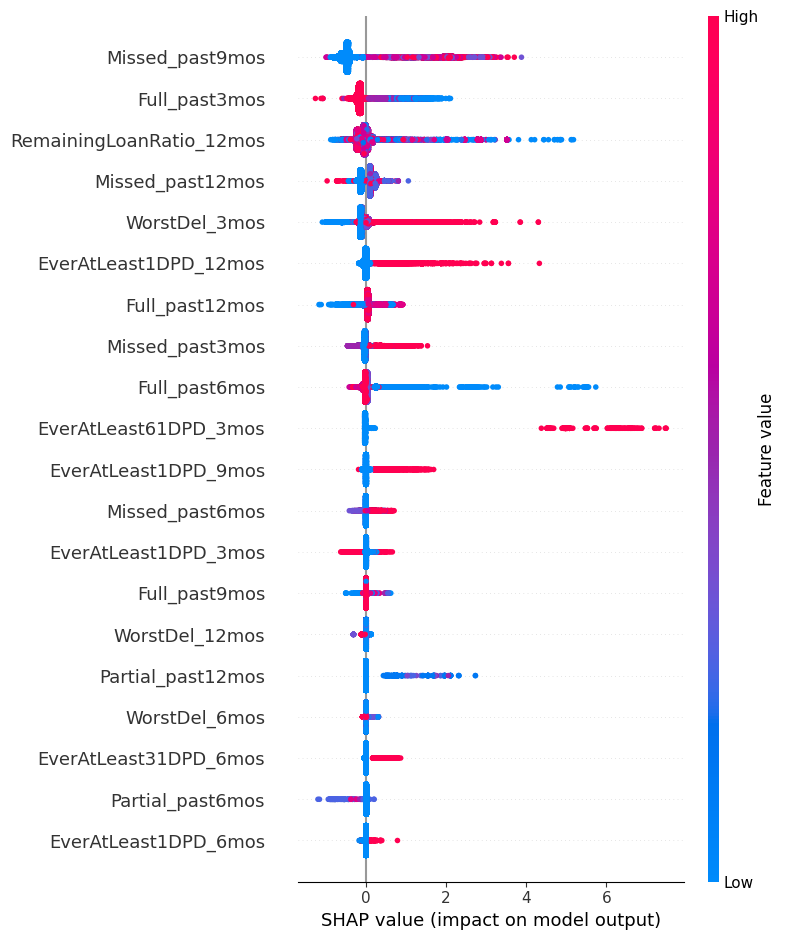

In [61]:
explainer = shap.Explainer(model)
shap_values = explainer(X_train_split)
shap.summary_plot(shap_values, X_train_split)

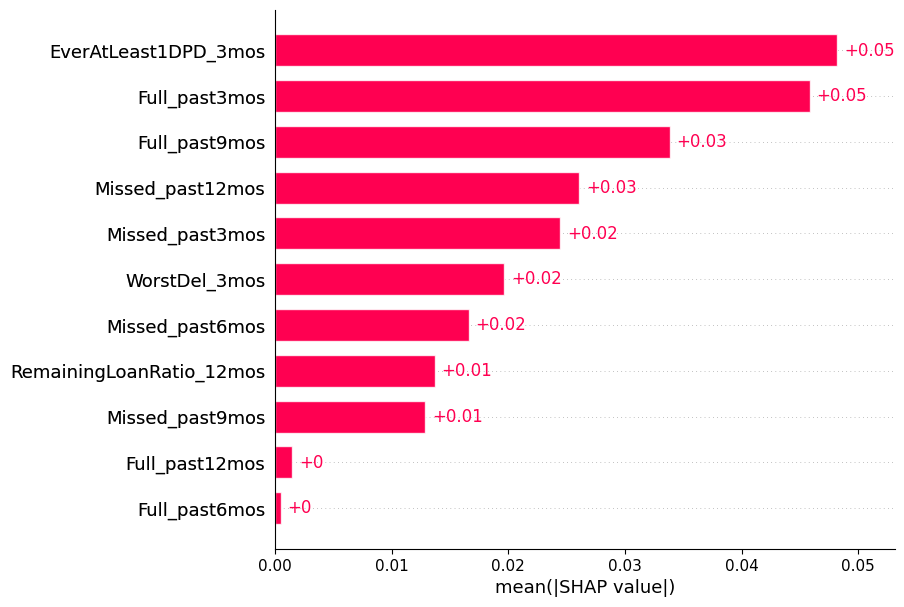

In [116]:
shap.plots.bar(shap_values, max_display=50)